# Shumovskaia Valentina. Assignment #6.

## Task 1.

Initial problem:
$$
\textrm{minimize } c^\top x\\
\textrm{subject to } Ax \leq b.
$$

It converts to:
$$
\textrm{minimize } F = tc^\top x + \phi(x),\\
\textrm{where }\phi(x) = -\sum_{i=1}^{m}\log(b_i-a^\top_ix)
$$

#####  Solution: 

Set $x = x_{0} = \begin{bmatrix} 0\\0\end{bmatrix}, t = 1$.

Repeat while duality gap is greater than $\varepsilon$:

1. Centering step.
Compute new $x^*$ by minimizing $F$ by Newtone method.
2. Update. $x = x$.
3. $t = \mu t$.

To implement Newtone's method: $\nabla \phi(x) = \sum_{i=1}^m \frac{1}{b_i-a_i^\top x}a_i = A^\top d,$ where $d_i = \frac{1}{b_i-a_i^\top x}.$

$\nabla^2 \phi(x) = \sum_{i=1}^m\frac{1}{(b_i-a_i^\top x)^2}a_ia_i^\top = A^\top \textrm{diag}(d)^2A.$

Also denote $f_0(x) = c^\top x$, $f_i(x) = b_i - a_i^\top x.$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#justtocheck
import cvxpy as cvx

In [3]:
class solver():
    def __init__(self, A, b, c, mu=1.5, gamma=0.0001, eps=1e-6, eps_n=1e-6):
        """Class initialization.

        Args:
            A (numpy array): Matrix A from LP problem.
            b (numpy array): Matrix b from LP problem.
            c (numpy array): Matrix c from LP problem.
            mu (float): barier method parameter.
            gamma (float): Newton method parameter.
            eps (float): barier method tolerance.
            eps_n (float) Newtone method tolerance.
        """
        self.A = A
        self.b = b
        self.c = c
        self.m = b.shape[0]
        self.t = 1.
        self.mu = mu
        self.gamma = gamma
        self.eps = eps
        self.eps_n = eps_n
    
    def f_0(self, x):
        """Value of f_0(x).

        Args:
            x (numpy array): parameter for function f_0 computation.
            
        Returns:
            numpy array: f_0(x) value.
        """
        return self.c.T@x
        
    def f_i(self, x, i):
        """Value of f_i(x).

        Args:
            x (numpy array): parameter for function f_i computation.
            i (int): index of f_i.
            
        Returns:
            numpy array: f_i(x) value
        """
        return self.b[i] - self.A[i].T@x
    
    def phi(self, x):
        """Value of phi(x).

        Args:
            x (numpy array): parameter for function phi computation.
            
        Returns:
            numpy array: phi(x) value.
        """
        phi = 0
        for i in range(self.m):
            phi -= np.log(self.f_i(x, i))
        return phi
    
    def d(self, x):
        """Value of d.

        Args:
            x (numpy array): parameter for computation of d.
            
        Returns:
            numpy array: d.
        """        
        d = np.zeros(self.m)
        for i in range(self.m):
            d[i] = 1./self.f_i(x, i)
        return d
    
    def grad_phi(self, x):
        """Value of gradient(phi(x)).

        Args:
            x (numpy array): parameter for function gradient phi computation.
            
        Returns:
            numpy array: value of gradient(phi(x)).
        """        
        d = self.d(x)
        return A.T@d
    
    def hess_phi(self, x):
        """Value of gradient(phi(x)).

        Args:
            x (numpy array): parameter for function gradient phi computation.
            
        Returns:
            numpy array: value of gradient(phi(x)).
        """    
        D = np.diag(self.d(x))
        D = D@D
        return self.A.T@D@self.A
    
    def grad_F(self, x):
        """Value of gradient(F(x)).

        Args:
            x (numpy array): parameter for function gradient F computation.
            
        Returns:
            numpy array: value of gradient(F(x)).
        """    
        return self.t*self.c.reshape(-1) + self.A.T@self.d(x)
    
    def hess_F(self, x):
        """Value of Hessian(F(x)).

        Args:
            x (numpy array): parameter for function Hessian F computation.
            
        Returns:
            numpy array: value of Hessian(F(x)).
        """    
        return self.hess_phi(x)
    
    def duality_gap(self):
        """Duality gap
        
        Returns:
            float: duality gap value.
        """
        return self.m/self.t

    def Newton(self, x_old):
        """Newton method
        
        Args:
            x_old (numpy array): initial value of x
        
        Returns:
            numpy array: new value of x after Newton's method implementation.
        """        
        inv_hess_F = np.linalg.inv(self.hess_F(x_old))
        grad_F = self.grad_F(x_old)
        x_new = x_old - self.gamma*inv_hess_F@grad_F
        while np.linalg.norm(x_new - x_old) > self.eps_n:
            x_old = x_new
            inv_hess_F = np.linalg.inv(self.hess_F(x_old))
            grad_F = self.grad_F(x_old)
            x_new = x_old - self.gamma*inv_hess_F@grad_F
        return x_new
    
    def barrier_method(self):
        """Barrier method
        
        Returns:
            numpy array: solution of LP: the first value is x*_1, the second value is x*_2.
            numpy array: values of x_1 on every step.
            numpy array: values of x_2 on every step.
        """    
        x = np.zeros(self.c.shape[0])
        xs_x1 = [x[0]]
        xs_x2 = [x[1]]
        while self.duality_gap() > self.eps:
            x = self.Newton(x)
            xs_x1.append(x[0])
            xs_x2.append(x[1])
            self.t *= self.mu
        return x, np.array(xs_x1), np.array(xs_x2) 
    
    def visualize(self, xs_x1, xs_x2, ndots=80):
        """Visualization of Barrier's method: plots the domain and values of x on every step.
        
        Args:
            x (numpy array): solution of LP: the first value is x*_1, the second value is x*_2.
            x_1 (numpy array): values of x_1 on every step.
            x_2 (numpy array): values of x_2 on every step.
        
        """
        plt.figure(figsize=(13,10))
        #plt.xlim(-1.2, 1.2)
        #plt.ylim(-1.2, 1.2)        
        x, y = np.mgrid[-1:1:2.0/ndots, -1:1:2.0/ndots]
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                dot = np.array([x[i,j], y[i,j]])
                if np.all(self.A@dot <= self.b):
                    plt.scatter(x[i,j], y[i,j], c='pink', s=70)
        plt.scatter(xs_x1, xs_x2, c='c', s=70)
        #plt.ylabel('x_2')
        #plt.xlabel('x_1')

In [4]:
A = np.array([[ 1.,  0.],[-1.,  0.],[ 0.,  1.],[ 0., -1.]])
b = np.array([1.,1.,1.,1.])
c = np.array([[3.],[-2.]])

In [5]:
#justtocheck
x = cvx.Variable(c.shape[0])
obj = cvx.Minimize(c.T*x)
constraints = [A@x<=b]
prob = cvx.Problem(obj,constraints)
prob.solve()
x.value, prob.value

(matrix([[-1.],
         [ 1.]]), -4.999999983286334)

In [6]:
s = solver(A, b, c)

In [7]:
x, xs_x, xs_y = s.barrier_method()

array([-0.99997686,  0.9999653 ])

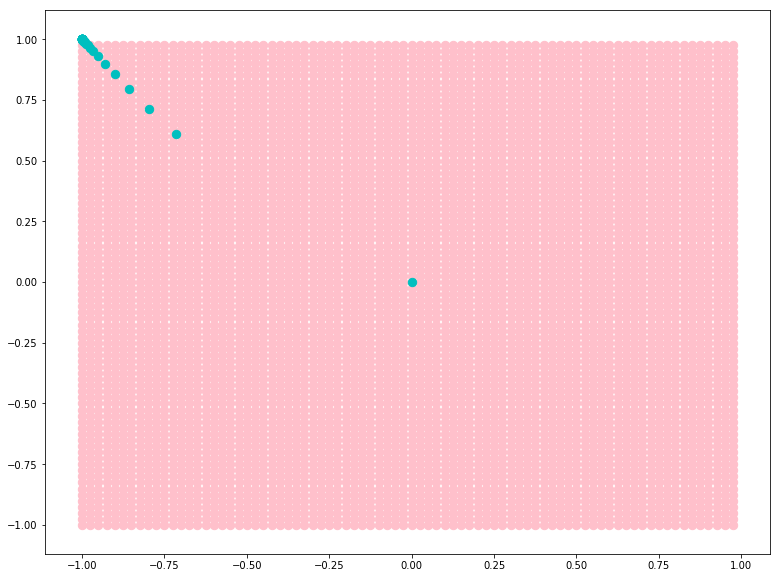

In [8]:
s.visualize(xs_x, xs_y)
x

In [9]:
A = np.array([[-1.,  0.],[ 0.,  1],[ 0., -1.]])
b = np.array([1.,.5,1.])
c = np.array([[1.],[.3]])

In [10]:
#justtocheck
x = cvx.Variable(c.shape[0])
obj = cvx.Minimize(c.T*x)
constraints = [A@x<=b]
prob = cvx.Problem(obj,constraints)
prob.solve()
x.value, prob.value

(matrix([[-1.],
         [-1.]]), -1.299999999918469)

array([-0.99996394, -0.99987981])

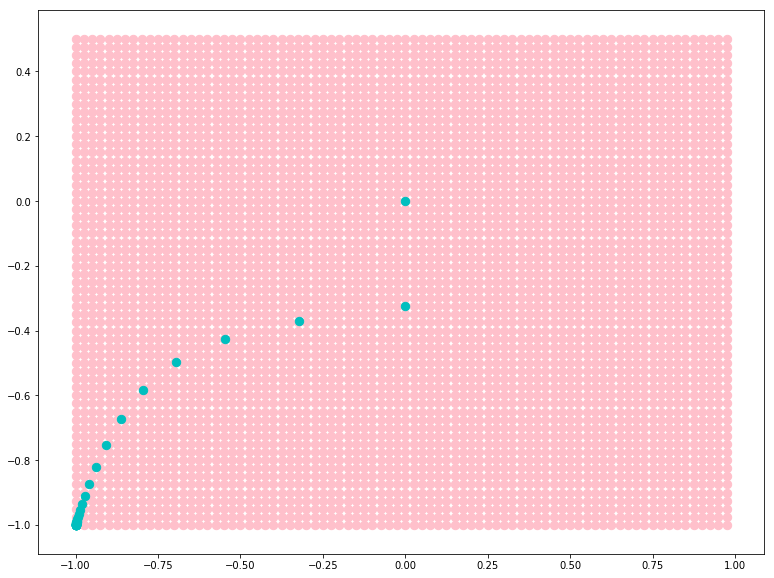

In [11]:
s = solver(A, b, c)
x, xs_x, xs_y = s.barrier_method()
s.visualize(xs_x, xs_y)
x

In [12]:
A = np.array([[ 1.,  0.8],[-1,  0.3],[ 0.,  1.]])
b = np.array([1.,1.,.5])
c = np.array([[1.],[-2.]])

In [13]:
#justtocheck
x = cvx.Variable(c.shape[0])
obj = cvx.Minimize(c.T*x)
constraints = [A@x<=b]
prob = cvx.Problem(obj,constraints)
prob.solve()
x.value, prob.value

(matrix([[-0.85],
         [ 0.5 ]]), -1.8500000013572258)

array([-0.84994572,  0.49996122])

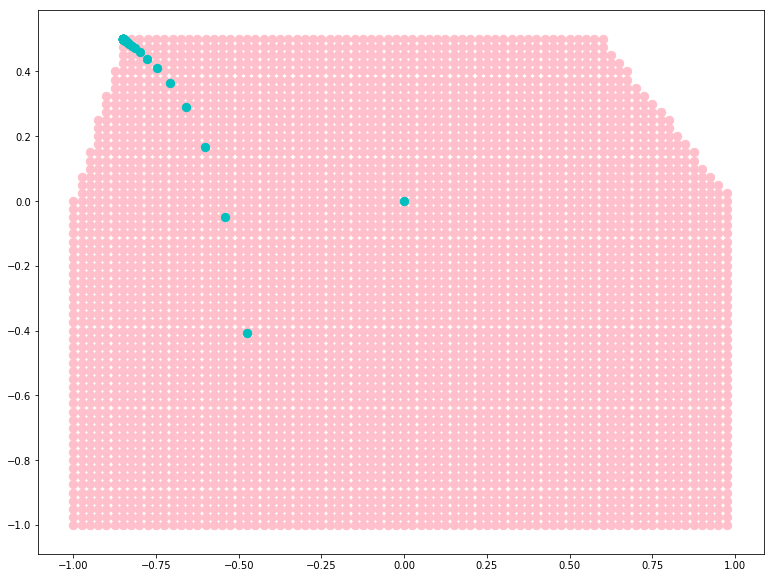

In [14]:
s = solver(A, b, c, mu=1.5, gamma=0.0001)
x, xs_x, xs_y = s.barrier_method()
s.visualize(xs_x, xs_y)
x

In [15]:
A = np.array([[ 1.,  0.8],[-1,  0.3],[ 0.7,  1.]])
b = np.array([1.,1.,.5])
c = np.array([[0.7],[-1.8]])

In [16]:
#justtocheck
x = cvx.Variable(c.shape[0])
obj = cvx.Minimize(c.T*x)
constraints = [A@x<=b]
prob = cvx.Problem(obj,constraints)
prob.solve()
x.value, prob.value

(matrix([[-0.70247934],
         [ 0.99173554]]), -2.2768595053793144)

array([-0.70245834,  0.99167112])

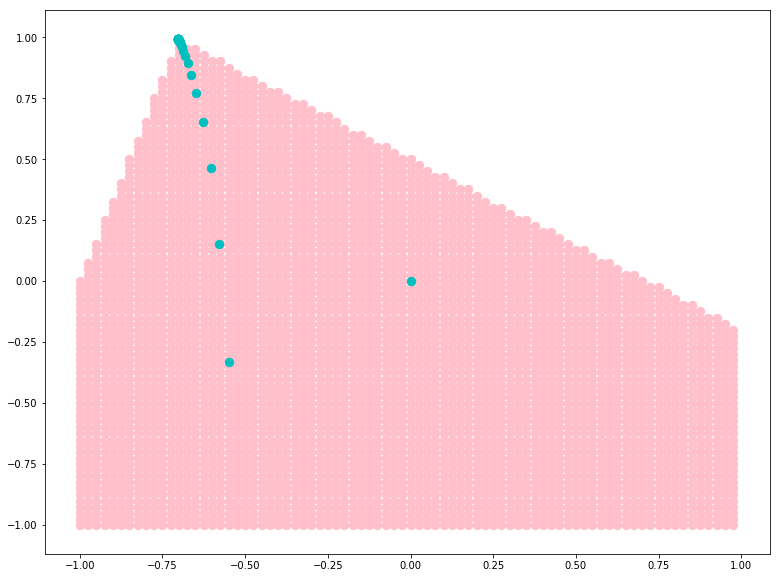

In [17]:
s = solver(A, b, c, mu=1.5, gamma=0.0001)
x, xs_x, xs_y = s.barrier_method()
s.visualize(xs_x, xs_y)
x

## Task 2.


Denote $x = (x_1,\dots,x_N), x_i = \mathbb{1}\{\textrm{there is a depot in the city}_i\}$,

$A -$ adjacency weighted matrix: $A_{ij} = \{\textrm{profit on a road between cities }i, j\}$

Our problem: 

$$
\textrm{maximize } \sum_{i=1}^N\sum_{j=1}^NA_{ij}\max\{0, x_i+x_j-1\} - 10\sum_{i=1}^N x_i\\
\textrm{subject to } x_i \in \{0,1\}, i = 1,\dots,N.\\
\\
\Leftrightarrow\\
\\
\textrm{maximize } \sum_{i=1}^N\sum_{j=1}^NA_{ij}\max\{0, x_i-x_j\} + \sum_{i=1}^N\big(\sum_{i=1}^NA_{ij} - 10\big) x_i\\
\textrm{subject to } x_i \in \{0,1\}, i = 1,\dots,N.\\
\\
\Leftrightarrow$$

We can rewrite this problem as mincut problem:
$\textrm{Denote } \tilde{x} = (x, x_t, x_s)$, $\textrm{denote } \tilde{U} \in \mathbb{R}^{N+2 \times N+2}$ such that the main minor of $N \times N$ size is equal to $A$. $x_s, x_t -$ source and sink. $U_{i, s} = \max\{0, \sum_{i=1}^NA_{ij} - 10\}$ -- max profits, $U_{i, t} = \max\{0, -\sum_{i=1}^NA_{ij} - 10\}$ -- max loss. Thus, in the following sum we are minimizing we're taking into account both sums we want to maximize above. 

$$\textrm{minimize } \sum_{i=1}^N\sum_{j=1}^NU_{ij}\max\{0, \tilde{x}_j-\tilde{x}_i\}\\
\textrm{subject to } \tilde{x}_s = 0, \tilde{x}_t = 1.\\
\\
\Leftrightarrow\\
\\
\textrm{minimize } \sum_{i=1}^N\sum_{j=1}^NU_{ij}d_{ij}\\
\textrm{subject to }\\
d_{ij} \geq \tilde{x}_j - \tilde{x}_i,\\
d_{ij} \geq 0,\\
\tilde{x}_s = 0, \tilde{x}_t = 1.
$$



In [18]:
def GetMatrix(links,cities):
    A = np.zeros((len(cities), len(cities)));
    for i in range(0, len(links), 3):
        A[cities.index(links[i]), cities.index(links[i + 1])] = links[i + 2]
    return A 

In [19]:
cities = ['Atlanta','Boston', 'Calgary', 'Charleston','Chicago','Dallas', 
          'Denver', 'Duluth', 'ElPaso','Helena', 'Houston', 'KansasCity', 'LasVegas',
          'LittleRock', 'LosAngeles', 'Miami', 'Montreal', 'Nashville',
          'NewOrleans', 'NewYork', 'OklahomaCity', 'Omaha', 'Phoenix',
          'Pittsburgh', 'Portland', 'Raleigh', 'SaintLouis','SaltLakeCity',
          'SanFrancisco','SantaFe', 'SaultStMarie', 'Seattle', 'Toronto',
          'Vancouver', 'Washington', 'Winnipeg']

blue = ['Winnipeg','Helena',4,
    'Portland','SaltLakeCity',6,
    'Omaha','Chicago',4,
    'Montreal','NewYork',3,
    'KansasCity','SaintLouis',2,
    'SantaFe','OklahomaCity',3,
    'Atlanta','Miami',5]

blue = GetMatrix(blue,cities)

white = ['Calgary','Winnipeg',6,
    'Chicago','Toronto',4,
    'SaintLouis','Chicago',2,
    'Pittsburgh','NewYork',2,
    'SanFrancisco','SaltLakeCity',5,
    'Phoenix','Denver',5,
    'LittleRock','Nashville',3]

white = GetMatrix(white,cities)

green = ['Portland','SanFrancisco',5,
    'Helena','Denver',4,
    'SaintLouis','Pittsburgh',5,
    'LittleRock','NewOrleans',3,
    'ElPaso','Houston',6]

green = GetMatrix(green,cities)

red = ['Helena','Omaha',5,
    'Denver','OklahomaCity',4,
    'ElPaso','Dallas',4,
    'NewOrleans','Miami',6,
    'NewYork','Boston',2,
    'Duluth','Chicago',3];

red = GetMatrix(red,cities)

purple = ['Helena','SaltLakeCity',3,
    'Denver','Omaha',4,
    'Duluth','Toronto',6,
    'Charleston','Miami',4,
    'SanFrancisco','LosAngeles',3]

purple = GetMatrix(purple,cities)

orange = ['LasVegas','SaltLakeCity',3,
    'Helena','Duluth',6,
    'Chicago','Pittsburgh',3,
    'Denver','KansasCity',4,
    'NewYork','Washington',2,
    'Atlanta','NewOrleans',4]

orange = GetMatrix(orange,cities);

black = ['LosAngeles','ElPaso',6,
    'Winnipeg','Duluth',4,
    'SaultStMarie','Montreal',5,
    'Nashville','Raleigh',3]

black = GetMatrix(black,cities)

yellow = ['Seattle','Helena',6,
    'ElPaso','OklahomaCity',5,
    'Nashville','Pittsburgh',4]

yellow = GetMatrix(yellow,cities)

gray = ['Vancouver','Seattle',1,
    'Portland','Seattle',1,
    'Vancouver','Calgary',3,
    'Seattle','Calgary',4,
    'Calgary','Helena',4,
    'Winnipeg','SaultStMarie',6,
    'Duluth','SaultStMarie',3,
    'SaultStMarie','Toronto',2,
    'Toronto','Montreal',3,
    'Montreal','Boston',2,
    'Toronto','Pittsburgh',2,
    'LasVegas','LosAngeles',2,
    'LosAngeles','Phoenix',3,
    'Phoenix','ElPaso',3,
    'ElPaso','SantaFe',2,
    'Phoenix','SantaFe',3,
    'SantaFe','Denver',2,
    'Duluth','Omaha',2,
    'Omaha','KansasCity',1,
    'KansasCity','OklahomaCity',2,
    'OklahomaCity','Dallas',2,
    'Dallas','Houston',1,
    'Houston','NewOrleans',2,
    'Dallas','LittleRock',2,
    'OklahomaCity','LittleRock',2,
    'LittleRock','SaintLouis',2,
    'SaintLouis','Nashville',2,
    'Nashville','Atlanta',1,
    'Atlanta','Charleston',2,
    'Charleston','Raleigh',2,
    'Atlanta','Raleigh',2,
    'Raleigh','Washington',2,
    'Raleigh','Pittsburgh',2,
    'Washington','Pittsburgh',2]

gray = GetMatrix(gray,cities)

N = len(cities)

weights = blue*1.0 + white*1.5 + green*2.0 + red*2.0 + purple*2.5 + orange*1.0 + black*1.0 + yellow*2.0 + gray*1.0
A = np.dstack([weights, weights.transpose()]).max(axis=2) #adjacency
c = 10*np.ones(N)

In [20]:
maxprof = 0.5*sum(A) - c

U = np.zeros((N+2, N+2))
U[:N, :N] = 0.5*A
U[:N,N] = np.array([np.max([0, -maxprof[i]]) for i in range(N)])
U[:N,N+1] = np.array([np.max([0, maxprof[i]]) for i in range(N)])
U[N,:N] = np.array([np.max([0, -maxprof[i]]) for i in range(N)])
U[N+1,:N] = np.array([np.max([0, maxprof[i]]) for i in range(N)])

In [21]:
d = cvx.Variable(N+2,N+2)
x = cvx.Variable(N+2)

constraints = [
    x[N] == 0,
    x[N+1] == 1,
    x >= 0,
    x <= 1,
    d >= 0
]

for i in range(N+2):
    for j in range(N+2):
        constraints += [d[i, j] >= x[j] - x[i]]

sum_to_min = 0
for i in range(N+2):
    for j in range(N+2):
        sum_to_min += U[i][j]*d[i,j]
        
objective = cvx.Minimize(sum_to_min)

problem = cvx.Problem(objective, constraints)
problem.solve(solver='GUROBI')

47.0

In [22]:
x = x.value[:N]

In [23]:
k = 0
for i in range(N):
    if x[i] == 1:
        k += 1
        print(k, cities[i])

1 Atlanta
2 Calgary
3 Charleston
4 Chicago
5 Dallas
6 Denver
7 Duluth
8 ElPaso
9 Helena
10 Houston
11 LittleRock
12 LosAngeles
13 Miami
14 Nashville
15 NewOrleans
16 OklahomaCity
17 Omaha
18 Phoenix
19 Pittsburgh
20 Portland
21 SaintLouis
22 SaltLakeCity
23 SanFrancisco
24 SaultStMarie
25 Seattle
26 Toronto
27 Winnipeg


<img src="TicketToRide0.png">